In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
dataset= pd.read_csv('./Irish_Tourism.csv')

In [3]:
dataset.head()

,Statistic Label,Quarter,Domestic,Reason for Journey,UNIT,VALUE
0,Number of Trips by Irish Residents,2000Q1,Domestic,All reasons for journey,Thousand,1169.0
1,Number of Trips by Irish Residents,2000Q1,Domestic,Holiday,Thousand,408.0
2,Number of Trips by Irish Residents,2000Q1,Domestic,Business,Thousand,161.0
3,Number of Trips by Irish Residents,2000Q1,Domestic,Visiting friends/relatives,Thousand,468.0
4,Number of Trips by Irish Residents,2000Q1,Domestic,Other reasons,Thousand,132.0


In [4]:
dataset.shape

(3600, 6)

In [6]:
# using the datatime package and creating the data feature using quarter feature
dataset['Date'] = pd.to_datetime(dataset['Quarter'].astype(str))

/var/folders/3g/lffy_gzj5nqgb76wmktqw4mr0000gn/T/ipykernel_39255/1784393431.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset['Date'] = pd.to_datetime(dataset['Quarter'].astype(str))


In [8]:
# converting the value feature into numeric type
dataset['VALUE'] = pd.to_numeric(dataset['VALUE'])

In [9]:
dataset.head()

,Statistic Label,Quarter,Domestic,Reason for Journey,UNIT,VALUE,Date
0,Number of Trips by Irish Residents,2000Q1,Domestic,All reasons for journey,Thousand,1169.0,2000-01-01
1,Number of Trips by Irish Residents,2000Q1,Domestic,Holiday,Thousand,408.0,2000-01-01
2,Number of Trips by Irish Residents,2000Q1,Domestic,Business,Thousand,161.0,2000-01-01
3,Number of Trips by Irish Residents,2000Q1,Domestic,Visiting friends/relatives,Thousand,468.0,2000-01-01
4,Number of Trips by Irish Residents,2000Q1,Domestic,Other reasons,Thousand,132.0,2000-01-01


In [10]:
# Calculating the basic statistics by type
basic_info = dataset.pivot_table(
        values='VALUE',
        index=['Domestic', 'Reason for Journey', 'Statistic Label'],
        aggfunc=['mean', 'median', 'std', 'count']
    ).round(2)

In [11]:
basic_info.head()

mean  \
                                                                              VALUE   
Domestic Reason for Journey      Statistic Label                                      
Domestic All reasons for journey Average Length of Stay by Irish Residents     2.93   
                                 Estimated Expenditure by Irish Residents    402.67   
                                 Number of Nights by Irish Residents        6377.42   
                                 Number of Trips by Irish Residents         2173.16   
         Business                Average Length of Stay by Irish Residents     2.25   

                                                                             median  \
                                                                              VALUE   
Domestic Reason for Journey      Statistic Label                                      
Domestic All reasons for journey Average Length of Stay by Irish Residents     2.70   
                                 Estimated Expenditure by Irish Residents    348.95   
                                 Number of Nights by Irish Residents        5169.50   
                                 Number of Trips by Irish Residents         2041.50   
         Business                Average Length of Stay by Irish Residents     2.20   

                                                                                std  \
                                                                              VALUE   
Domestic Reason for Journey      Statistic Label                                      
Domestic All reasons for journey Average Length of Stay by Irish Residents     0.82   
                                 Estimated Expenditure by Irish Residents    228.05   
                                 Number of Nights by Irish Residents        3158.80   
                                 Number of Trips by Irish Residents          835.17   
         Business                Average Length of Stay by Irish Residents     0.62   

                                                                           count  
                                                                           VALUE  
Domestic Reason for Journey      Statistic Label                                  
Domestic All reasons for journey Average Length of Stay by Irish Residents    90  
                                 Estimated Expenditure by Irish Residents     90  
                                 Number of Nights by Irish Residents          90  
                                 Number of Trips by Irish Residents           90  
         Business                Average Length of Stay by Irish Residents    89

In [12]:
# calculating the quarter patterns and adding as new feature
dataset['Quarter_Num'] = dataset['Date'].dt.quarter
quarterly_patterns = dataset.groupby(['Quarter_Num', 'Statistic Label', 'Domestic'])['VALUE'].mean().round(2)

In [13]:
print(quarterly_patterns.head())

Quarter_Num  Statistic Label                            Domestic
1            Average Length of Stay by Irish Residents  Domestic       2.42
                                                        Outbound       6.72
             Estimated Expenditure by Irish Residents   Domestic     110.94
                                                        Outbound     450.95
             Number of Nights by Irish Residents        Domestic    1612.94
Name: VALUE, dtype: float64


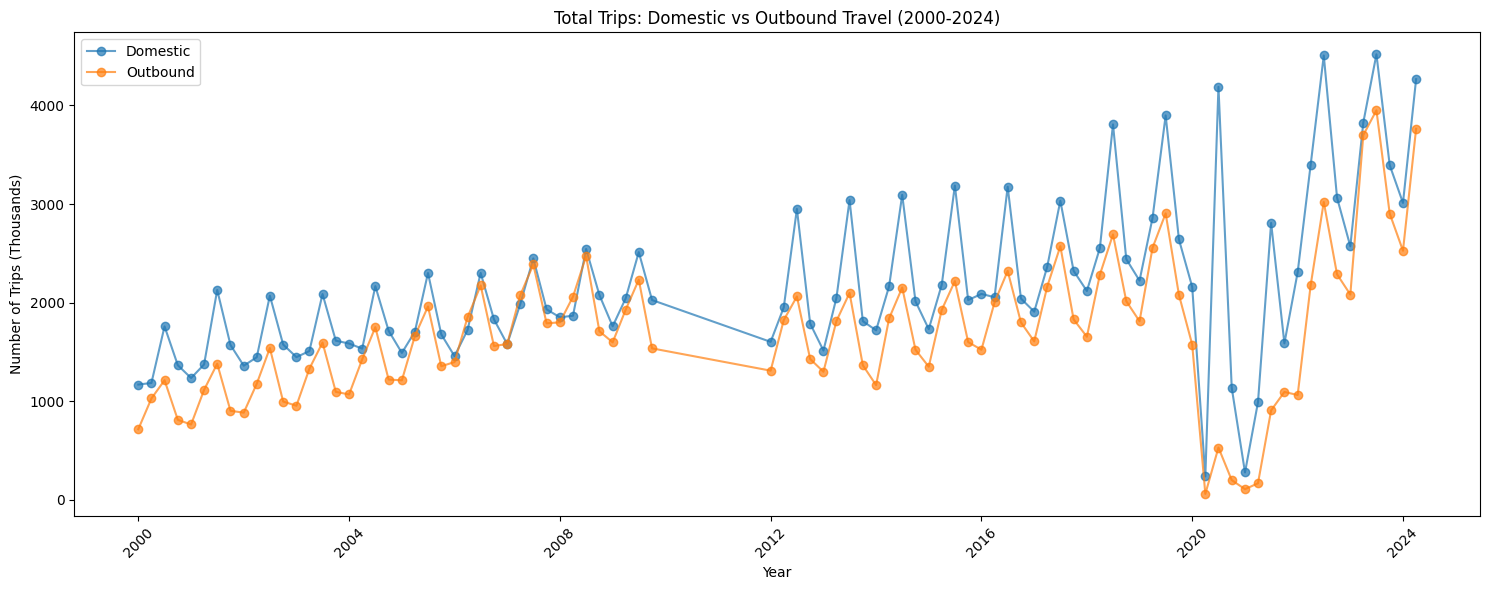

In [15]:
# Plotting the trip graph to check the patterns from 2000 to 2024
trips_df = dataset[
        (dataset['Statistic Label'] == 'Number of Trips by Irish Residents') & 
        (dataset['Reason for Journey'] == 'All reasons for journey')
    ] 
plt.figure(figsize=(15, 6))
for travel_type in ['Domestic', 'Outbound']:
    data = trips_df[trips_df['Domestic'] == travel_type]
    plt.plot(data['Date'], data['VALUE'], label=travel_type, marker='o', alpha=0.7)

plt.title('Total Trips: Domestic vs Outbound Travel (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Trips (Thousands)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

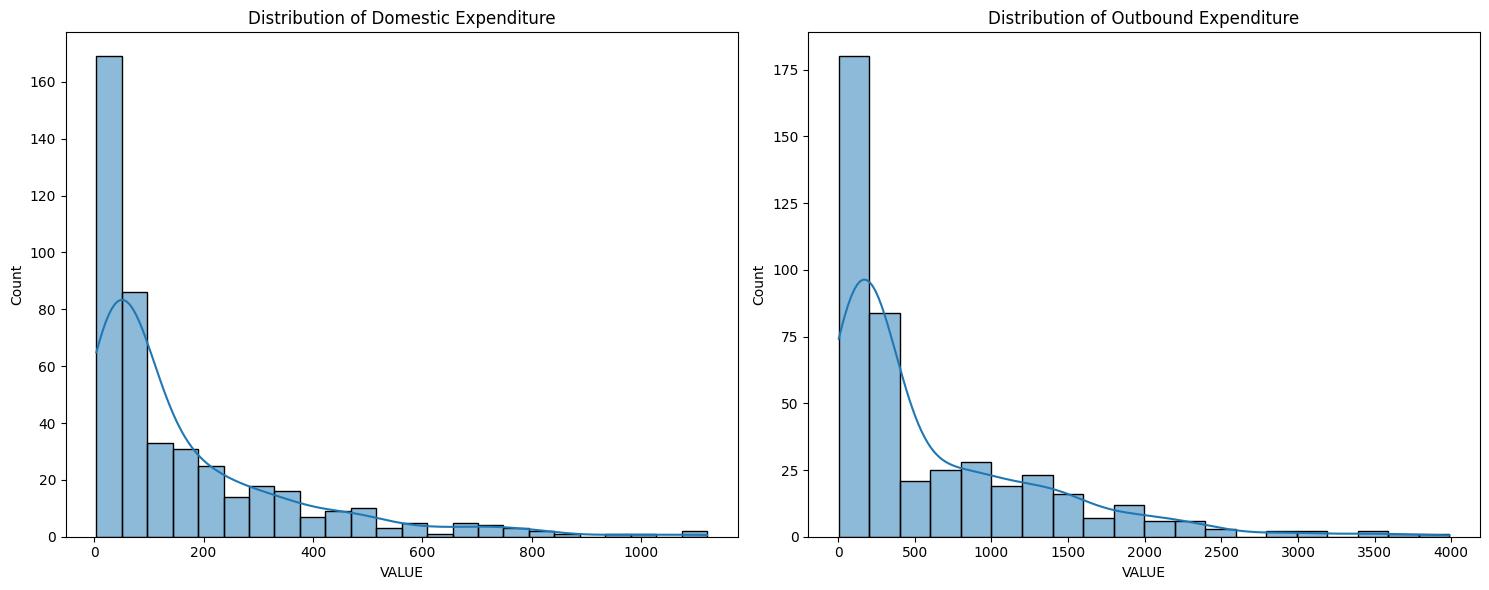

In [16]:
# Plotting the domestic and outbound expenditure distribution 
expenditure_df = dataset[dataset['Statistic Label'].str.contains('Expenditure')]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
domestic_exp = expenditure_df[expenditure_df['Domestic'] == 'Domestic']['VALUE']
sns.histplot(domestic_exp, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Domestic Expenditure')
outbound_exp = expenditure_df[expenditure_df['Domestic'] == 'Outbound']['VALUE']
sns.histplot(outbound_exp, ax=axes[1], kde=True)
axes[1].set_title('Distribution of Outbound Expenditure')
plt.tight_layout()
plt.show()

In [18]:
# validating using shapiro test
shapiro = {
        'Domestic': stats.shapiro(domestic_exp),
        'Outbound': stats.shapiro(outbound_exp)
    }

In [19]:
print(shapiro)

{'Domestic': ShapiroResult(statistic=nan, pvalue=1.0), 'Outbound': ShapiroResult(statistic=nan, pvalue=1.0)}


In [28]:
# Calculating probability of high spending trips for binomial analysis
spending_data = dataset[dataset['Statistic Label'].str.contains('Expenditure')]
spend_threshold = spending_data['VALUE'].median()  
total_trials = len(spending_data) 
high_spending_count = len(spending_data[spending_data['VALUE'] > spend_threshold])  
high_spend_prob = high_spending_count / total_trials

In [29]:
trials_range = np.arange(0, total_trials + 1)
high_spend_binomial_dist = stats.binom.pmf(trials_range, total_trials, high_spend_prob)

In [30]:
# Calculating Poisson analysis for trip counts
total_no_of_trips = dataset[dataset['Statistic Label'].str.contains('Number of Trips')]
avg_trip = total_no_of_trips['VALUE'].mean()

In [32]:
distribution_results={
        'binomials': {'n': total_trials, 'p': high_spend_prob},
        'poisson': avg_trip
    }
print(distribution_results)

{'binomials': {'n': 900, 'p': 0.4911111111111111}, 'poisson': 785.6685520361991}


In [33]:
domestic_outbound_df = dataset[
    (dataset['Statistic Label'] == 'Number of Trips by Irish Residents') & 
    (dataset['Reason for Journey'] == 'All reasons for journey')
]

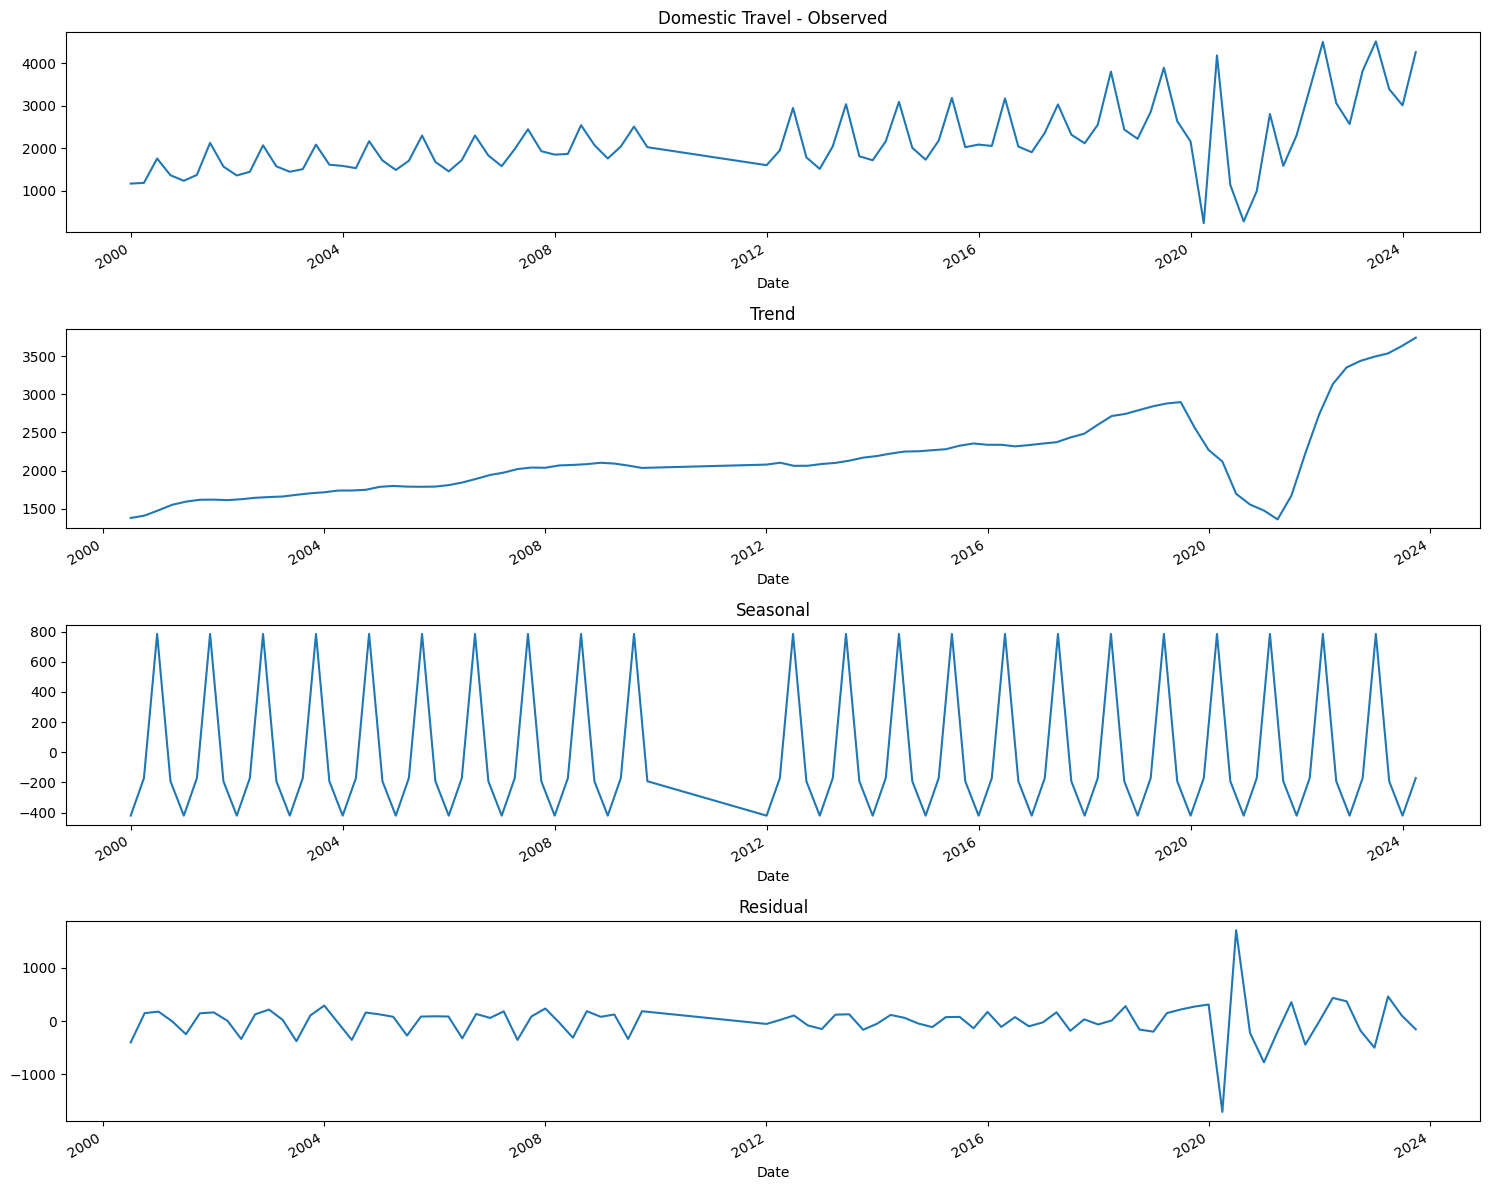

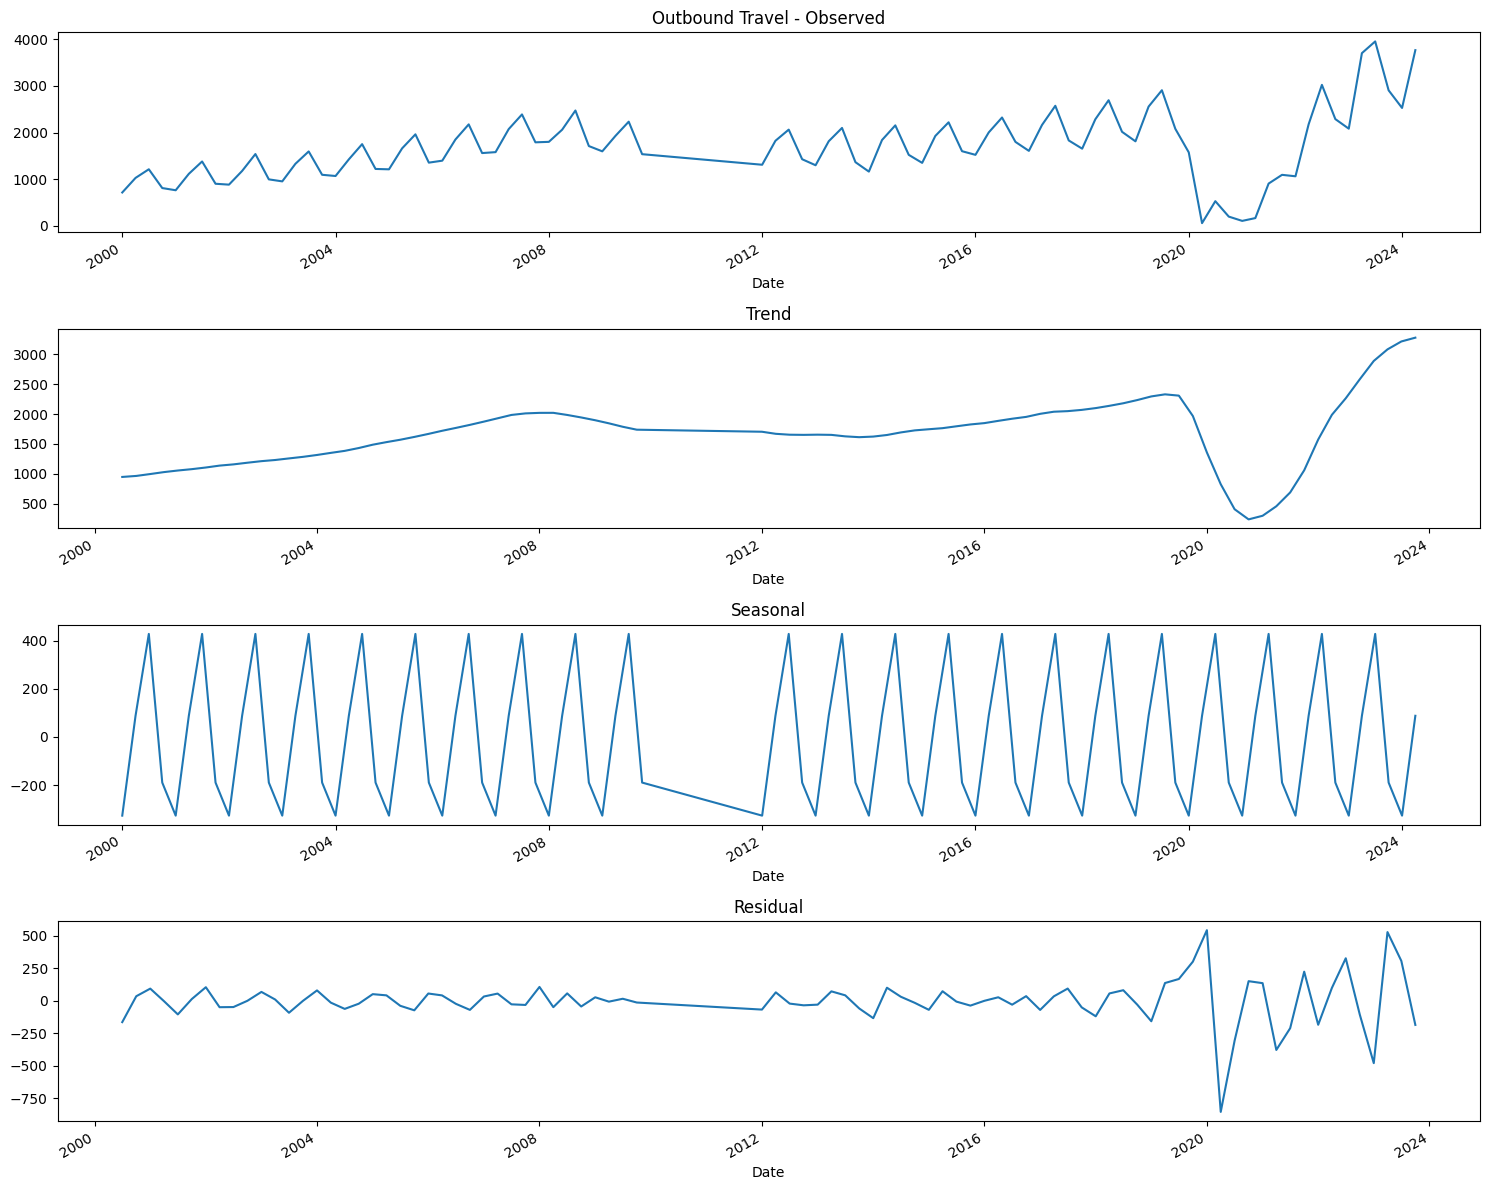

In [34]:
results = {}
for travel_type in ['Domestic', 'Outbound']:
    ts_data = domestic_outbound_df[domestic_outbound_df['Domestic'] == travel_type].set_index('Date')['VALUE']
    # using decomposition for seasonal patterns
    decomposition = seasonal_decompose(ts_data, period=4)
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0])
    axes[0].set_title(f'{travel_type} Travel - Observed')
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_title('Trend')
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_title('Seasonal')
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_title('Residual')
    plt.tight_layout()
    plt.show()
    results[travel_type] = decomposition